全部trainデータで残差平方和を出す

In [1]:
from config.quality_metrics import qm_names

dataset_names = ["les_miserables", "1138_bus", "USpowerGrid"]
params_names = sorted(["number_of_pivots", "number_of_iterations", "eps"])

In [2]:
# import pandas as pd

# from config.paths import root_path


# data = pd.DataFrame()

# for dataset_name in dataset_names:
#     data_path = root_path.joinpath(
#         f"data/experiments/regression_analysis/grid/{dataset_name}.pkl"
#     )

#     data = pd.concat([data, pd.read_pickle(data_path)])

# data = data.set_index("data_id")

In [3]:
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from tqdm import tqdm


# for qm_name in qm_names:
#     data[f"{qm_name}_ss"] = 0


# dqss = {}
# for dataset_name in dataset_names:
#     dd = data.query(f'dataset_name == "{dataset_name}"')
#     dqss[dataset_name] = {}
#     for qm_name in qm_names:
#         dqss[qm_name] = StandardScaler()
#         dqss[qm_name].fit(np.array(dd[qm_name]).reshape(-1, 1))


# for i, row in tqdm(data.iterrows()):
#     for qm_name in qm_names:
#         data.at[i, f"{qm_name}_ss"] = dqss[qm_name].transform(
#             np.array(row[qm_name]).reshape(-1, 1)
#         )[0][0]

In [4]:
# data.to_pickle(root_path.joinpath('data/experiments/regression_analysis/grid/ss.pkl'))

In [5]:
import pandas as pd
from config.paths import root_path

data = pd.read_pickle(
    root_path.joinpath(
        "data/experiments/regression_analysis/grid/ss.pkl"
    )
)


In [6]:
# parameter（名前＋値）を3つ受け取って、評価値を返す関数
from itertools import combinations
import numpy as np


def regression_func(ps, qm_name, model_df):
    qs = []
    cs = list(combinations(ps, 2))

    for c in cs:
        p1 = c[0]
        p2 = c[1]
        pt = list(
            filter(
                lambda x: x[0] != p1[0] and x[0] != p2[0],
                ps,
            )
        )[0]

        mdf = model_df.query(f"{p1[0]} == {p1[1]} & {p2[0]} == {p2[1]}")
        target_model = mdf[qm_name].values[0]
        q = target_model.predict(np.array([pt[1]]).reshape(-1, 1))[0]
        if type(q) == type(np.array([])):
            q = q[0]
        qs.append(q)

    result = sum(qs) / len(qs)
    return result

In [7]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import r2_score


cs = list(combinations(params_names, 2))
degs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# degs = [5]

models = [
    {
        "model_df": pd.read_pickle(
            root_path.joinpath(
                f"data/experiments/regression_analysis/grid/grid_models_poly_{deg}.pkl"
            )
        ),
        "name": deg,
    }
    for deg in degs
]
models.append(
    {
        "model_df": pd.read_pickle(
            root_path.joinpath(
                f"data/experiments/regression_analysis/grid/grid_models_lightgbm.pkl"
            )
        ),
        "name": "lgb",
    }
)

ss = []
results = []
for model in models:
    result_array = []

    for c in tqdm(cs, level=0):
        pa = c[0]
        pb = c[1]
        pt = list(filter(lambda x: x != pa and x != pb, params_names))[0]

        pavs = sorted(list(set(data[pa])))[::3]
        pbvs = sorted(list(set(data[pb])))[::3]
        ptvs = sorted(list(set(data[pt])))[::3]

        for ptv in tqdm(ptvs, level=1, leave=False):
            for pav in pavs:
                for pbv in pbvs:
                    result = {}
                    result[pa] = pav
                    result[pb] = pbv
                    result[pt] = ptv

                    for qm_name in qm_names:
                        result[qm_name] = regression_func(
                            [
                                [pa, pav],
                                [pb, pbv],
                                [pt, ptv],
                            ],
                            qm_name=qm_name,
                            model_df=model["model_df"],
                        )
                        l = data.query(
                            f"{pa} == {pav} & {pb} == {pbv} & {pt} == {ptv}"
                        )

                        result[f"{qm_name}_test_labels"] = list(
                            l[f"{qm_name}_ss"].values
                        )

                    result_array.append(result)

    result = pd.DataFrame(result_array)
    results.append(result)

100%|██████████| 3/3 [02:44<00:00, 54.94s/it]


In [8]:
from statistics import mean

for result in results:
    s = {}
    for qm_name in qm_names:
        s[qm_name] = 0

    for i, row in result.iterrows():
        d = row.to_dict()
        for qm_name in qm_names:
            s[qm_name] += (mean(d[f"{qm_name}_test_labels"]) - d[qm_name]) ** 2
            # for l in d[f"{qm_name}_test_labels"]:
            #     s[qm_name] += (l - d[qm_name]) ** 2
    print(model["name"], s)
    ss.append(s)

lgb {'angular_resolution': 16.088819485595433, 'aspect_ratio': 107.47446707568967, 'crossing_angle': 14.90251591510136, 'crossing_number': 14.442629090862411, 'gabriel_graph_property': 49.94450494470155, 'ideal_edge_lengths': 71.25381403082301, 'neighborhood_preservation': 650.4676544352188, 'node_resolution': 12.777775311613276, 'stress': 29.19839504221565}
lgb {'angular_resolution': 8.757228292149092, 'aspect_ratio': 67.49691281434367, 'crossing_angle': 8.151713139320435, 'crossing_number': 7.47782961723073, 'gabriel_graph_property': 31.82403518125043, 'ideal_edge_lengths': 37.17328598045739, 'neighborhood_preservation': 331.10549725508537, 'node_resolution': 10.194680029661356, 'stress': 19.313515644140896}
lgb {'angular_resolution': 4.173889662210831, 'aspect_ratio': 49.226912847996516, 'crossing_angle': 4.824361377127532, 'crossing_number': 4.175163997840126, 'gabriel_graph_property': 22.428253944114957, 'ideal_edge_lengths': 19.55627764385287, 'neighborhood_preservation': 187.932

In [9]:
list(results[0]['angular_resolution_test_labels'])

[[-31.81644796092387,
  -31.6360845448515,
  -31.907193285430274,
  -31.74674647432412,
  -31.73088370305732,
  -31.91165272891658,
  -31.74765084829871,
  -31.770164779093246,
  -31.88557111395189,
  -31.864546036306514,
  -31.056858243441823,
  -30.591515137746885,
  -30.601859157670876,
  -30.852360398144047,
  -30.604363329098376,
  -30.780872805289754,
  -30.57212155592692,
  -30.382934024546657,
  -30.121806066419243,
  -30.459369151133203,
  -7.251529284200671,
  -2.62231707765245,
  -5.177211076399112,
  -5.198108713648925,
  -4.740653327462006,
  -6.170726049706283,
  -3.7441625885731993,
  -4.661156396854183,
  -5.640884518840526,
  -6.795455688292527],
 [-31.90535413291971,
  -31.87582257059701,
  -31.80116902192608,
  -31.636256621730784,
  -31.543106102347746,
  -31.46903606249304,
  -31.753588147539634,
  -31.818934989354002,
  -31.725974983658745,
  -31.8261906821287,
  -29.56024028683101,
  -29.47574407004604,
  -29.770942603366496,
  -29.89734859693543,
  -29.534054843

In [10]:
for qm_name in qm_names:
    print(len(list(l[f"{qm_name}_ss"].values)))

30
30
30
30
30
30
30
30
30


In [11]:
data

,angular_resolution,aspect_ratio,crossing_angle,crossing_number,gabriel_graph_property,ideal_edge_lengths,neighborhood_preservation,node_resolution,stress,number_of_pivots,...,dataset_name,angular_resolution_ss,aspect_ratio_ss,crossing_angle_ss,crossing_number_ss,gabriel_graph_property_ss,ideal_edge_lengths_ss,neighborhood_preservation_ss,node_resolution_ss,stress_ss
data_id,,,,,,,,,,,,,,,,,,,,,
bb2b7119-883e-4089-b4be-ec98b2150af5,995.080139,-0.643333,1003.676880,2363.0,9.997450e+04,44.471745,-0.270000,2.262040e+04,503.152740,5,...,les_miserables,-31.816448,5.120018,-8.384722,-5.620575,-0.308825,-1.461341,-38.880922,-17.686193,-3.635988
4e9ce796-cd3d-48d0-a551-59dfc4c7b4b3,1029.114502,-0.781833,995.103638,2506.0,8.457808e+04,34.284576,-0.209524,1.489409e+04,543.295227,5,...,les_miserables,-31.636085,1.763756,-8.388968,-5.592872,-0.309017,-1.465270,-28.827610,-17.686209,-3.635806
5f4303bd-4857-47b3-bc66-664737b0acd7,977.956604,-0.762826,827.940247,1980.0,6.019839e+04,40.869736,-0.372973,2.084025e+04,340.642731,5,...,les_miserables,-31.907193,2.224368,-8.471767,-5.694773,-0.309320,-1.462730,-55.998718,-17.686197,-3.636724
3c22943f-fe59-4f84-ac0f-d6d70f0c9259,1008.232727,-0.820159,915.304993,2173.0,7.827785e+04,49.901482,-0.349270,2.451729e+04,393.484222,5,...,les_miserables,-31.746746,0.835009,-8.428494,-5.657384,-0.309095,-1.459246,-52.058369,-17.686190,-3.636485
891e3ff8-8a70-4e41-a1b9-b2aed4773038,1011.226013,-0.962789,968.700562,2514.0,8.352752e+04,44.770088,-0.286076,2.164487e+04,443.041748,5,...,les_miserables,-31.730884,-2.621335,-8.402046,-5.591322,-0.309030,-1.461226,-41.553319,-17.686195,-3.636260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a83b2b88-140d-499b-8183-569259bf8f71,6797.813477,-0.886762,17081.269531,32263.0,1.407859e+07,4406.994141,-0.045754,9.360683e+09,725598.687500,100,...,USpowerGrid,-1.065151,-0.778963,-0.421185,0.171907,-0.134696,0.221358,-1.603149,1.520015,-0.349764
b74f4d5e-21b9-4a1d-a8c6-661abfc9f0e8,6873.985352,-0.889589,16705.615234,30398.0,1.053275e+07,3451.234619,-0.043643,8.086209e+09,736127.187500,100,...,USpowerGrid,-0.661482,-0.847473,-0.607254,-0.189397,-0.178866,-0.147294,-1.252343,-1.094952,-0.302048
f946aa86-82b5-4260-8ec3-a4a6fc931e17,6669.931641,-0.870054,17320.759766,36757.0,1.607190e+07,5071.155762,-0.040720,8.936648e+09,727798.062500,100,...,USpowerGrid,-1.742854,-0.374092,-0.302561,1.042523,-0.109865,0.477537,-0.766316,0.649979,-0.339796


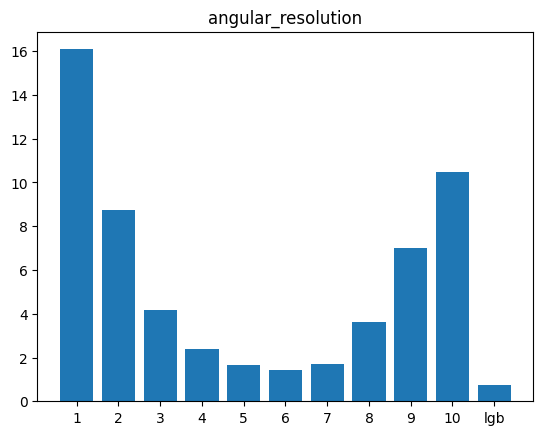

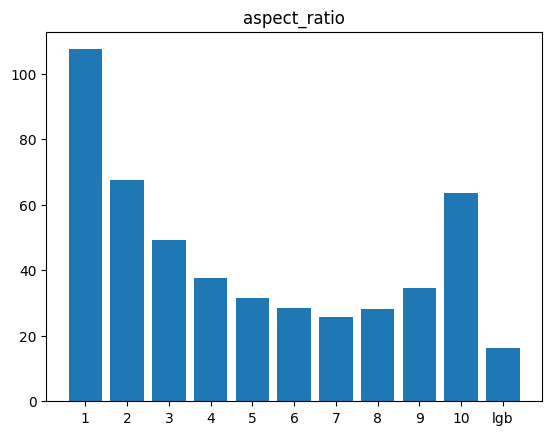

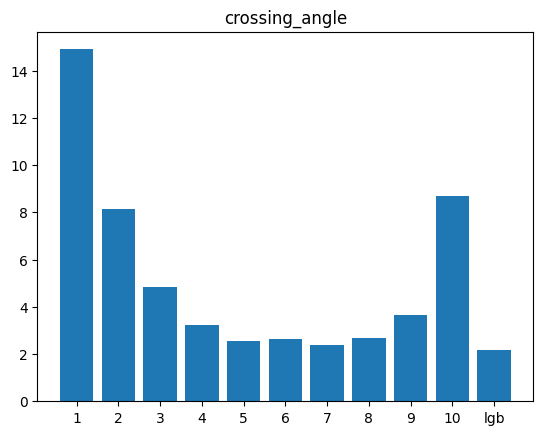

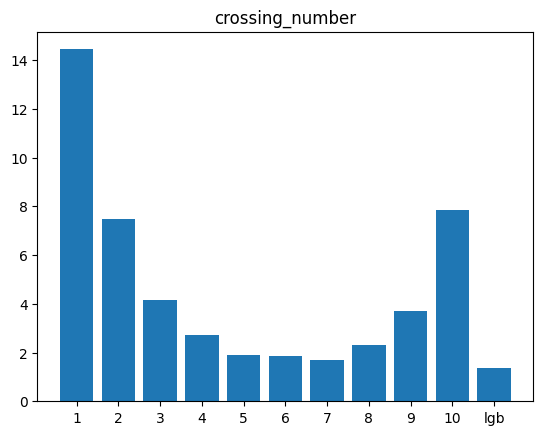

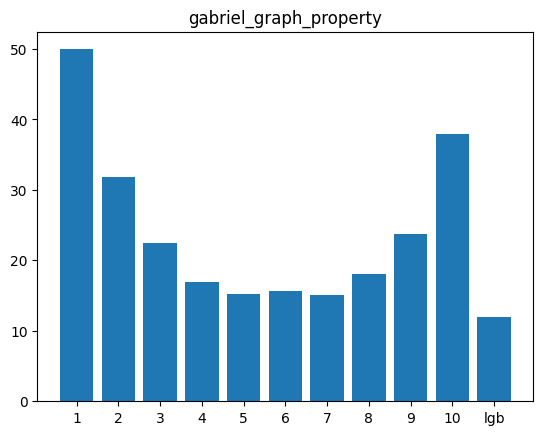

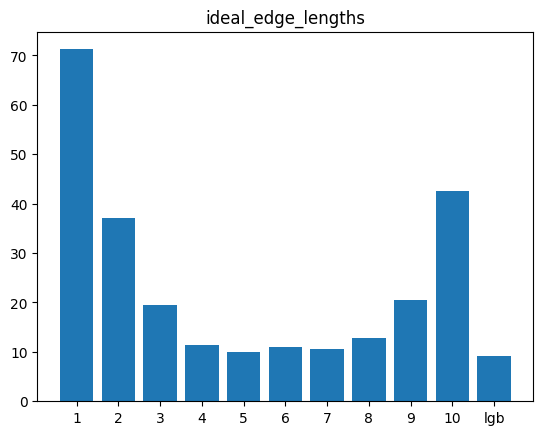

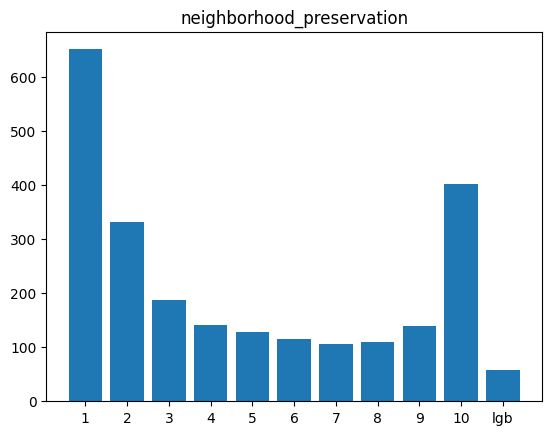

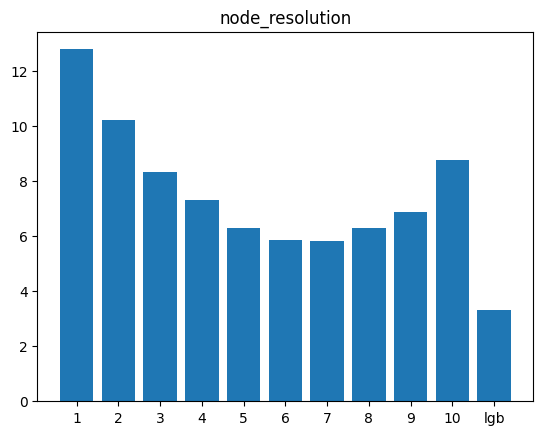

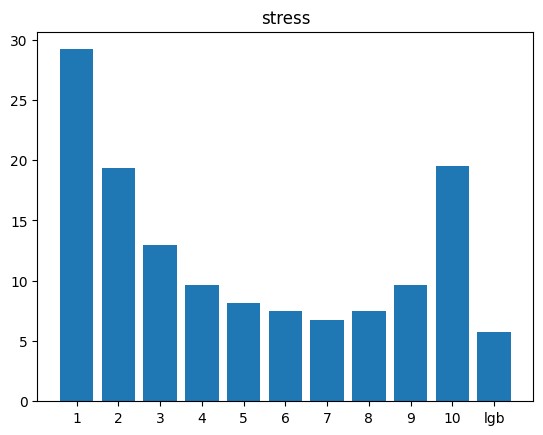

In [12]:
import matplotlib.pyplot as plt

bd = {}
for qm_name in qm_names:
    bd[qm_name] = []
for s in ss:
    for qm_name in qm_names:
        bd[qm_name].append(s[qm_name])

for qm_name in qm_names:
    plt.title(qm_name)
    plt.bar(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'lgb'],bd[qm_name] )
    plt.show()